# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

# Exercise 07.1
In the MD/MC code we have provided, include tail corrections for potential energy, $U$, and pressure $P$.

# Exercise 07.2

Use the MD/MC code to <span style="color:red">print out instantaneous values of potential energy per particle, $U/N$, along **equilibrated** Monte Carlo simulations</span> (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

## Some observations

The metropolis move consists in a uniform random translation of the particles. So what changes is the positional distribution of the particles, as a consequence of this the simulation evolves at costant temperature. Basically we are working in the Canonical ensemble, T is constant due to heat reservoir, while energy changes. Instead the Verlet algorithm works in the Microcanonical ensemble.

To modify the acceptance rate we should change the delta of the move. In the liquid and solid phase we can choose suitable deltas to satisfy the 50% rule. In the gas phase instead the rate is always higher than 50%, but it's not a problem. We know that tipically large moves are rejected and small moves are accepted. So to decrease the acceptance rate we should increase the delta of the move. But our gas is diluted, so even moves with a large delta will probably be accepted, since the particle moved will probably find a good position without sovrappositions, contrary to what happens in a solid phase. Hence with a gas we will have an acceptance rate higher than 50%, but obviously this isn't a signal that our Metropolis stepes of the stochastic process will be correlated. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path="DATA/Exercise7.2/"

In [3]:
def load_eq_data(path ,Y_file) : 
    X, Y, Y_err = np.loadtxt(path + Y_file, usecols = (0,1,3) ,unpack=True)
    return X, Y, Y_err

def plot_eq_data(ax, x, y, phase, N, obs) :
    ax.plot(x, y)#, 
    ax.set_xlabel('i step')
    ax.set_ylabel(f"${obs}$")
    ax.set_title(f"{phase} phase, {N} particles , Metropolis")
    ax.grid(True)

In [4]:
def load_Y_data(path ,Y_file) : 
    X, Y, Y_err = np.loadtxt(path + Y_file, usecols = (0,2,3) ,unpack=True)
    return X, Y, Y_err

def plot_Y_data(ax, x, y, err, phase, N, obs) :
    ax.errorbar(x, y, yerr=err)#, 
    ax.set_xlabel('i block')
    ax.set_ylabel(f"${obs}$")
    ax.set_title(f"{phase} phase, {N} particles , Metropolis")
    ax.grid(True)

## Equilibration

As first thing we use the potential energy per particle to study the equilibration process.

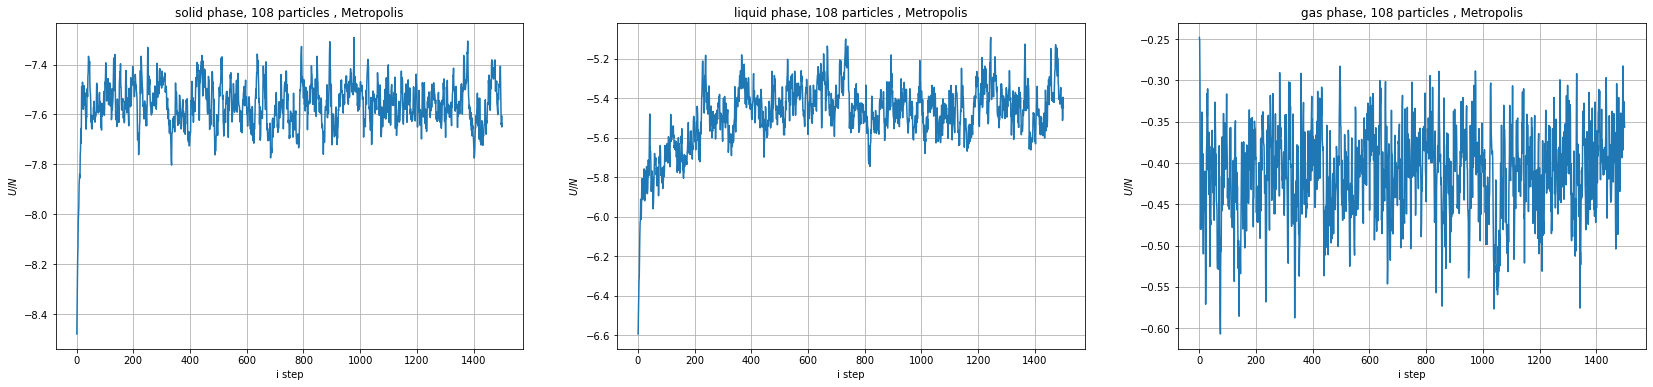

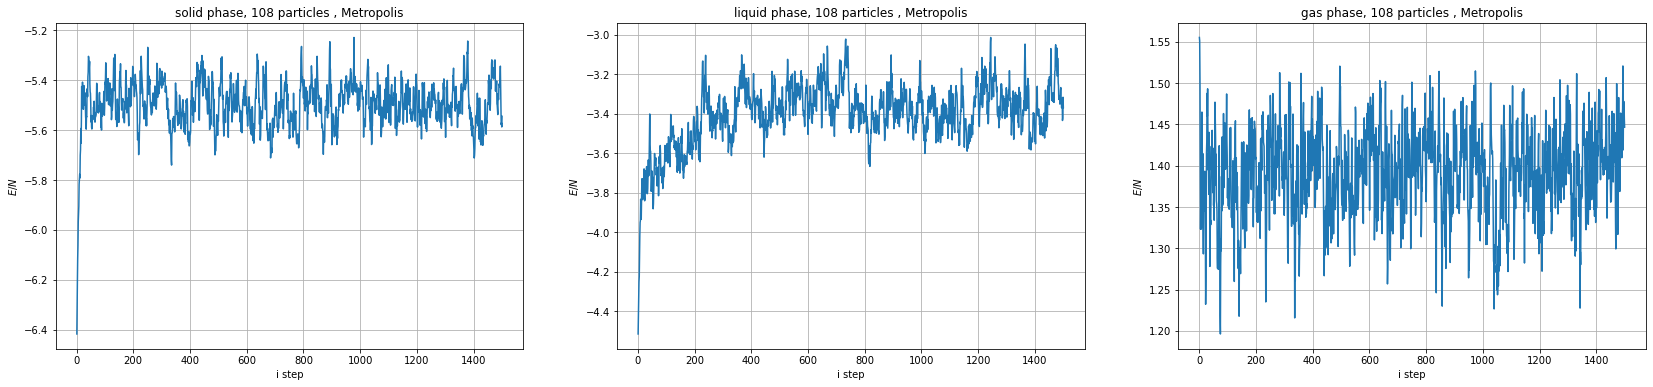

In [5]:
phases=["solid", "liquid", "gas"]
Npart=108
Nplot=3

X= np.empty(Nplot, dtype=object) #vector with i bloxk step index
U= np.empty(Nplot, dtype=object) #value of the observable per block
U_err= np.empty(Nplot, dtype=object) #err of the observable per block
E= np.empty(Nplot, dtype=object) #value of the observable per block
E_err= np.empty(Nplot, dtype=object) #er

fig, axes = plt.subplots(1, Nplot, figsize=(28.5, 6))

for ax, j in zip(axes, range(Nplot)) :  #Equilibration plots 
    filename="output_" + phases[j] + "_epot.dat"
    X[j], U[j], U_err[j] = load_eq_data(path + "Equilibration/" , filename)
    plot_eq_data(ax, X[j] , U[j], phases[j], Npart, "U/N") 
    
fig, axes = plt.subplots(1, Nplot, figsize=(28.5, 6))

for ax, j in zip(axes, range(Nplot)) :  #Equilibration plots 
    filename="output_" + phases[j] + "_etot.dat"
    X[j], E[j], E_err[j] = load_eq_data(path + "Equilibration/" , filename)
    plot_eq_data(ax, X[j] , E[j], phases[j], Npart, "E/N")    

Given that the temperature is constant the energy and potential energy evolution is the same.
The behaviour during the equilibration process is the same found in lecture 4. Though the gas equilibrates faster. I think this is related to the high acceptenace rate fo metropolis moves in the gas phase. This feature makes the evolution of the gas fast, since in a single move a particle con go directly to the other side of the box. Instead, when we used Verlet, a particle in the gas phase had to travel quite long distances before finding other particles to interact with, and hence equilibrate the system.



## Potential energy autocorrelation

After having equilibrated the system, we want to study the energy autocorrelation. Then we will study how the blocking method allows us to have correct estimates of the observables' averages and their uncertainties, regardless of the correlation among different data.

Here we load the autocorrelation data.

In [8]:
def load_autocorr_data(path ,Y_file) : #y is the typo of observable
    Y = np.loadtxt(path + Y_file, usecols = (1) ,unpack=True)
    return  Y

In [9]:
path = "DATA/Exercise7.2/Autocorrelation/"

In [10]:
phases=["solid", "liquid", "gas"]
U= np.empty(len(phases), dtype=object)

#load istantaneous values
for j in range(len(phases)) :  
    filename="output_" + phases[j] + "_epot.dat"
    U[j] = load_autocorr_data(path, filename)

1. <span style="color:red.">Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. <span style="color:red">Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

### Part 1, autocorrelation

Here is our first attempt to calculate the autocorellation of our datset.

In [11]:
Nobs=len(phases)
tmax=len(U[0])

dim_Ac=500
Ac = [[0 for x in range(dim_Ac)] for y in range(Nobs)]     


In [12]:
%%time
tp=0
uu=0
u1=0
u2=0

for i, phase_U in zip(range(len(U)),U) : 
    var=np.std(phase_U)**2   #calculate variance of the values of U for that phase
    for j in range(dim_Ac) : #run along the Ac vector
        uu=0 #auxialiary variables
        u1=0
        u2=0
        for tp in range(tmax-j) : #make the t' sum
            uu+=phase_U[tp]*phase_U[tp+j]
            u1+=phase_U[tp]
            u2+=phase_U[tp+j]
        uu/=(tmax-j)
        u1/=(tmax-j)
        u2/=(tmax-j)
        #print((uu-u1*u2)/(var))
        Ac[i][j]=(uu-u1*u2)/(var)


KeyboardInterrupt: 

The previous algorithm takes too long to get the autocorellations, I have stolen a different implementation from this site: https://scicoding.com/4-ways-of-calculating-autocorrelation-in-python/.

In [13]:
def get_autocorrelation(vector, nsteps) :
    
    # Nearest size with power of 2
    size = 2 ** np.ceil(np.log2(2*len(U[0]) - 1)).astype('int')

    # Variance
    var = np.var(vector)

    # Normalized U[0]
    ndata = vector - np.mean(vector)

    # Compute the FFT
    fft = np.fft.fft(ndata, size)

    # Get the power spectrum
    pwr = np.abs(fft) ** 2

    # Calculate the autocorrelation from inverse FFT of the power spectrum
    acorr = np.fft.ifft(pwr).real / var / len(vector)

    x=np.arange(nsteps)
    return x, acorr[:nsteps]

As a sanity check we verified that both method produce the same results, and they did. But now we use only the faster implementation.

In [14]:
def plot_Ac(ax, x, y, phase, N) :
    ax.plot(x, y)#, 
    ax.set_xlabel('Montecarlo step')
    ax.set_ylabel(r"$Ac_{U/N}[t]$")
    ax.set_title(f"Energy autocorrelation in {phase} phase, {N} particles , Metropolis")
    ax.grid(True)

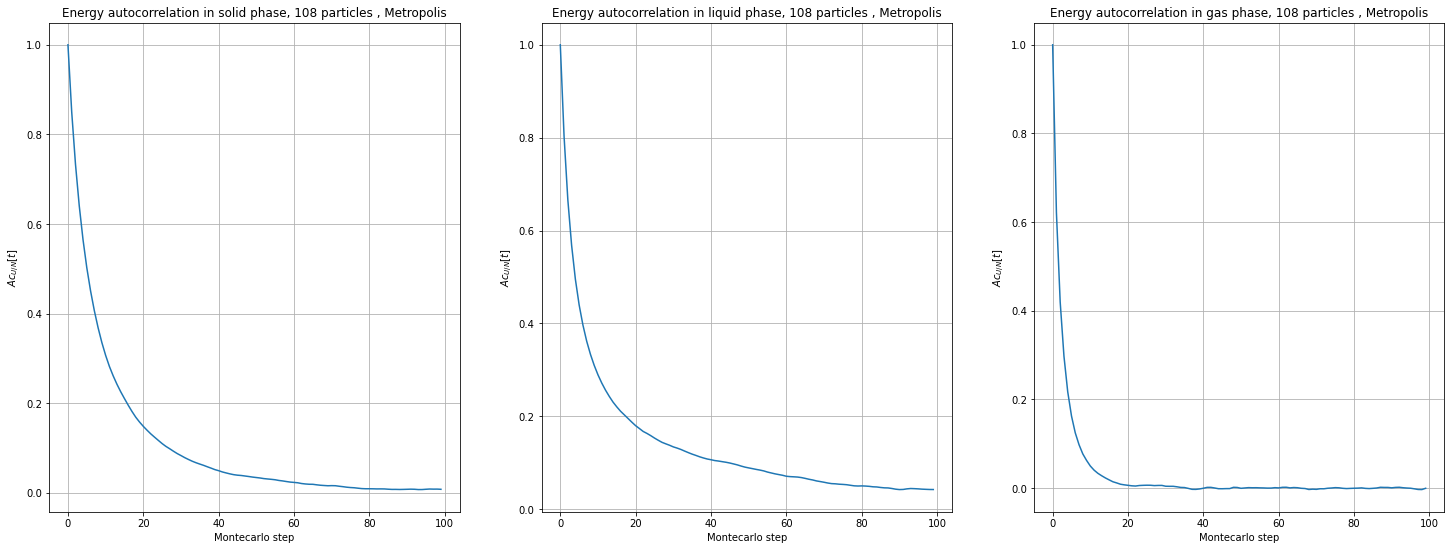

In [15]:
fig, axes = plt.subplots(1, len(U), figsize=(25, 9))

for ax, j in zip(axes, range(len(U))) :  
    x, y = get_autocorrelation(U[j], 100)
    plot_Ac(ax, x , y, phases[j], 108) 

we can see that the autocorellation decreases exponentially. The decrease is faster in the gas phase. This is again a consequnce of the fact that, in the dilute gas, large moves of particles can be easily accepeted. Hence after few Monte Carlo steps we get a completely different microstate. These functions probably can be fitted with an exponential function, in this way we could find the characteristic memory scale of the stochastic process.


### Part 2, uncertainties estimation

Here we get the estimates for the potential energy uncertainty with different block lengths. We want to see how data blocking impacts the estimate. In particular we expect to find that after a  block length big enough the estimates reach a plateau, as a sign of the fact that the bias has become irrelevant. 

In [16]:
M=500000 #data set size
N=[ 1000, 500, 250, 100, 75, 50,40, 30, 25, 20, 15, 10,9, 8, 7, 6, 5] #number of blocks in which the data set will be divided
L= [ int(M/i) for i in N] # number of steps per block for each case 


In [17]:
def data_block(vector, nstep, nblock) : #get the error for nstep and nblock values
    A=np.zeros(nblock)
    for i in range(nblock) :
        for j in range(nstep) :
            k = j+i*nstep ## index to keep tack of which part of the U values we used
            A[i]+=vector[k]
        #print(k)
        A[i]/=nstep
    return np.std(A)    

In [18]:
sigma = [[0 for x in range(len(L))] for y in range(Nobs)]     


In [19]:
for i, phase_U in zip(range(len(U)), U) : #phase_U not really necessary
    for j in range(len(L)) :
        sigma[i][j] = data_block(phase_U, L[j], N[j])# i phase index


In [20]:
def plot_sigma(ax, x, y, phase, N) :
    ax.plot(x, y ,  color='blue', marker='o', linestyle='solid', linewidth=2, markersize=8) 
    ax.set_xlabel('N steps per block')
    ax.set_ylabel(f"$\sigma$")
    ax.set_title(f"Effect of correlation bias in potential energy SDE estimator in {phase} phase")
    ax.grid(True)

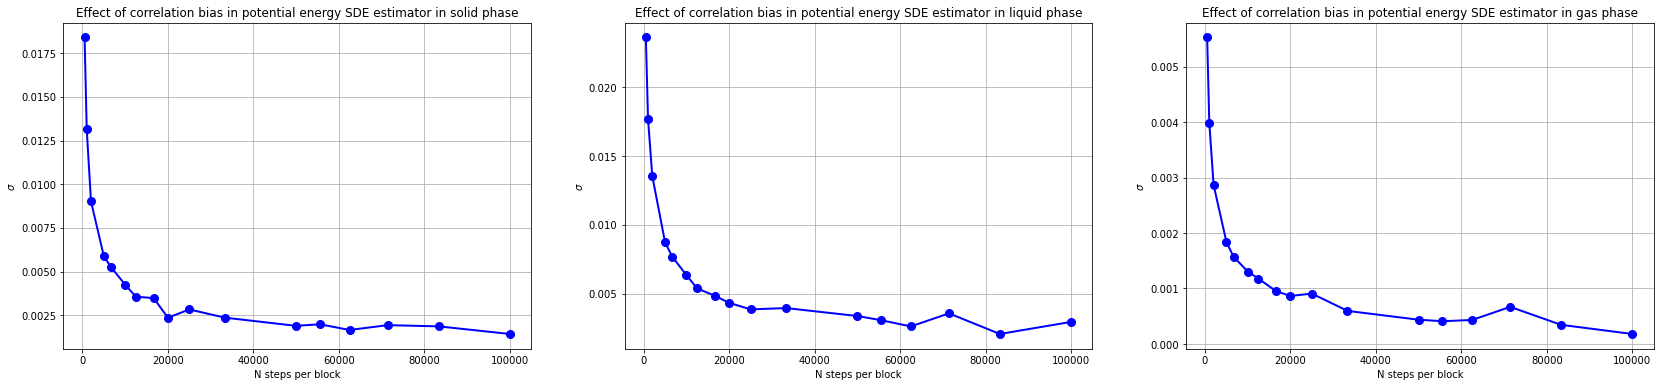

In [21]:
x=np.arange(len(sigma[0]))
Npart=108

fig, axes = plt.subplots(1, Nobs, figsize=(28.5, 6))
for ax, j in zip(axes, range(Nobs)) :  
    plot_sigma(ax, L, sigma[j], phases[j], Npart)


As we can see, increasing the number of steps per block the errors reach a plateau that we expect to be their true value. 

### Exercise 07.3

<span style="color:red">Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$ inside the MD/MC code</span>: average value of $g(r)$ in each block, final average value of $g(r)$ with statistical uncertainties in a separate file.



There is a subtle point in the reason for using \[0,L/2\] as distance interval, while the max distance (in periodic boundary conditions PBC) that we can find is $\sqrt3L/2$. The point is that in our procedure to obtain the $g(r)$ function, there is a normalization of the function on spherical shells. So sampling all distances in the box up to $\sqrt3L/2$ wouldn't be consistent with our normalization. So in our code we accept only distances lower or equal $L/2$, selecting them with an if(dr<=box/2).

In [22]:
path="DATA/Exercise7.3/gofr/"
path2=""

In [23]:
def load_gr_data(path ,Y_file) : #y is the typo of observable
    X, Y, Y_err = np.loadtxt(path + Y_file ,unpack=True)
    return X, Y, Y_err

In [24]:
def plot_gr_hist(ax, X, Y , phase) :
    ax.plot(X, Y) 
    ax.set_xlabel('dr bins')
    ax.set_ylabel(f"$g(r)$")
    ax.set_title(f"g(r) for {phase} phase")
    ax.grid(True)
    
def plot_gr_err(ax, X, Y , phase) :
    ax.plot(X, Y) 
    ax.set_xlabel('dr bins')
    ax.set_ylabel(f"$\sigma$")
    ax.set_title(f"errors on g(r) estimate for {phase} phase")
    ax.grid(True)    

In [25]:
phases=["solid", "liquid", "gas"]
Nphase=len(phases)

X= np.empty(Nphase, dtype=object) 
gr = np.empty(Nphase, dtype=object) 
gr_err= np.empty(Nphase, dtype=object) 

for i in range(Nphase) :
    filename = "gr_final_" + phases[i] + ".dat" 
    X[i], gr[i], gr_err[i] = load_gr_data(path, filename)     

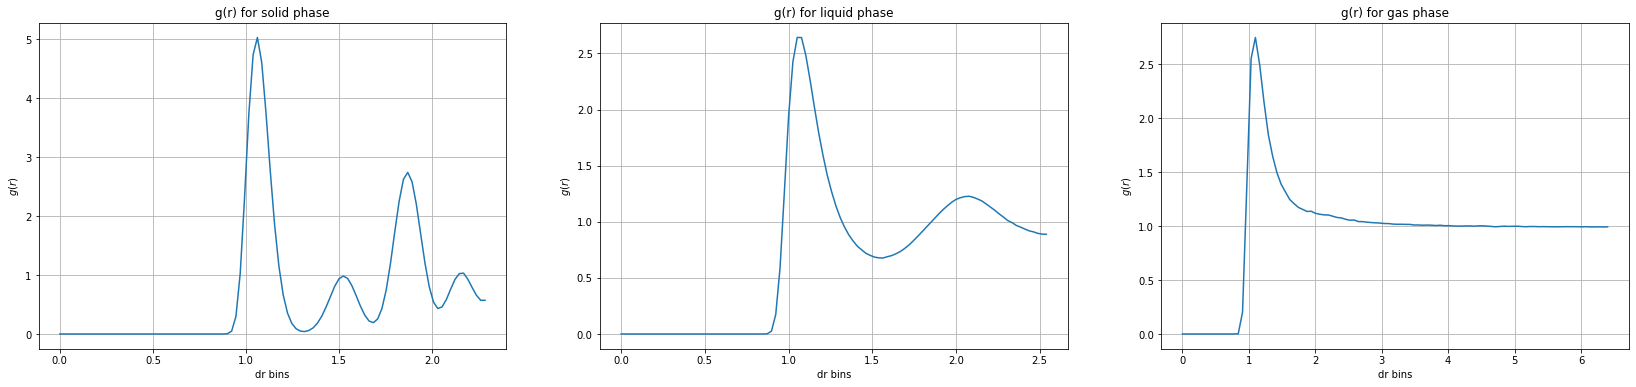

In [26]:
fig, axes = plt.subplots(1, Nphase, figsize=(28.5, 6))

for ax, j in zip(axes, range(Nobs)) :  
    plot_gr_hist(ax, X[j], gr[j], phases[j]) #le incertezze sono piccolissime

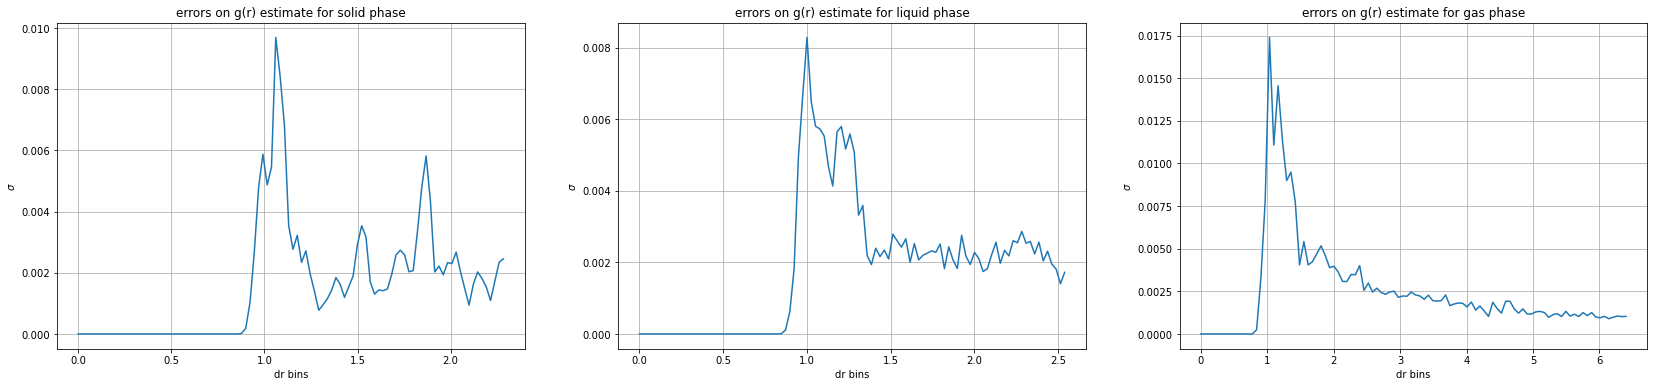

In [27]:
fig, axes = plt.subplots(1, Nphase, figsize=(28.5, 6))

for ax, j in zip(axes, range(Nobs)) :  
    plot_gr_err(ax, X[j], gr_err[j] , phases[j]) 

The radial distribution, or two point function, allows us to gain information on the spatial correlation of the system. The radial distribution represents the probability of finding two particles at a certain distance $r$, normalized for the ideal gas case (completely random distribution). As we can see in the gas phase in fact at large distances the $g(r)$ is one. This happens since at large distances our model is becoming equivalent to an ideal gas (no interactions), in fact the potential we use to model the interactions is a Lennard-Jones potential. 

The $g(r)$ is zero for the first bins, this is due to the fact that up to a certain distance the shells of the atoms are full. The first peak is a high probable distance value and should be associated to the first non null shell.
In the liquid case we are able to see even the second one, as a second local maximum.
The solid presents a different phenomenology, the repeated peaks indicate a phase with a long range order, in which even atoms at a high distance are correlated. This is a property characteristic of a ordered phase. In fact if we imagine to perturb the lattice of a solid, the displacement of a particle will perturb even particles far apart, thanks to the propagation of the vibrations.


### Exercise 07.4

By means of your upgraded MC code, equilibrate and <span style="color:red">perform MC NVT simulations via a Lennard-Jones model</span> of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

show in pictures the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in natural units ... <span style="color:red"> and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.</span>

## Monte Carlo predictions for the observables' ensemble averages

Here we plot the estimates for the observables' values. These estimates are obtained using the Metropolis algorithm and taking in consideration all the prior analysis about equilibration and data blocking.

In [35]:
def load_Y_data(path ,Y_file) : #y is the typo of observable
    X, Y, Y_err = np.loadtxt(path + Y_file, usecols = (0,2,3) ,unpack=True)
    return X, Y, Y_err

def plot_Y_data(ax, x, y, err, phase, obs, typeofev) :
    ax.errorbar(x, y, yerr=err, label=f"{typeofev}")#, 
    ax.set_xlabel('i block')
    ax.set_ylabel(f"${obs}$")
    ax.set_title(f"{phase} phase, 108 particles ")
    ax.legend()
    ax.grid(True)

In [36]:
phase = "solid"
path_MC = "DATA/Exercise7.4/Estimates_MC/"
path_MD = "DATA/Exercise7.4/Estimates_MD/"

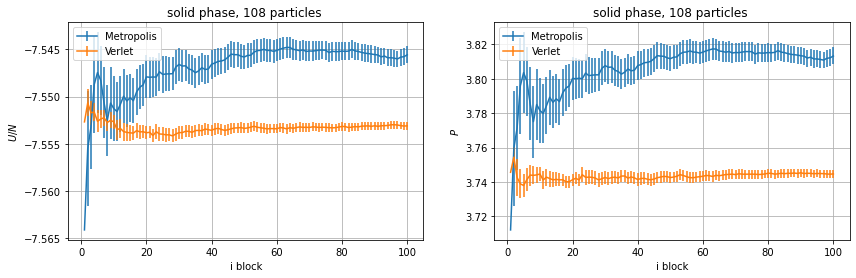

In [37]:
#phases=["solid", "liquid", "gas"]
strings=["epot", "pres"]
Obs=["U/N", "P"]
Nobs=len(Obs)

Nblocks_vec= np.empty(Nobs, dtype=object)
Y_vec= np.empty(Nobs, dtype=object) 
Y_err_vec= np.empty(Nobs, dtype=object)

fig, axes = plt.subplots(1, Nobs, figsize=(14, 4))

for ax, i in zip(axes, range(Nobs)) :
    filename="output_" + phase + "_" + strings[i] + ".dat"
    Nblocks_vec[i], Y_vec[i], Y_err_vec[i] = load_Y_data(path_MC, filename)
    plot_Y_data(ax, Nblocks_vec[i], Y_vec[i], Y_err_vec[i], phase ,  Obs[i], "Metropolis" )
    Nblocks_vec[i], Y_vec[i], Y_err_vec[i] = load_Y_data(path_MD, filename)
    plot_Y_data(ax, Nblocks_vec[i], Y_vec[i], Y_err_vec[i], phase ,  Obs[i], "Verlet")

In [38]:
phase = "liquid"

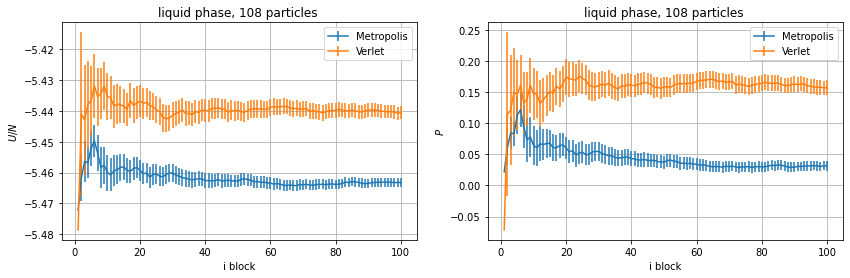

In [39]:
strings=["epot", "pres"]
Obs=["U/N", "P"]
Nobs=len(Obs)

Nblocks_vec= np.empty(Nobs, dtype=object)
Y_vec= np.empty(Nobs, dtype=object) 
Y_err_vec= np.empty(Nobs, dtype=object)

fig, axes = plt.subplots(1, Nobs, figsize=(14, 4))

for ax, i in zip(axes, range(Nobs)) :
    filename="output_" + phase + "_" + strings[i] + ".dat"
    Nblocks_vec[i], Y_vec[i], Y_err_vec[i] = load_Y_data(path_MC, filename)
    plot_Y_data(ax, Nblocks_vec[i], Y_vec[i], Y_err_vec[i], phase , Obs[i],  "Metropolis")
    Nblocks_vec[i], Y_vec[i], Y_err_vec[i] = load_Y_data(path_MD, filename)
    plot_Y_data(ax, Nblocks_vec[i], Y_vec[i], Y_err_vec[i], phase ,  Obs[i], "Verlet")

In [40]:
phase = "gas"

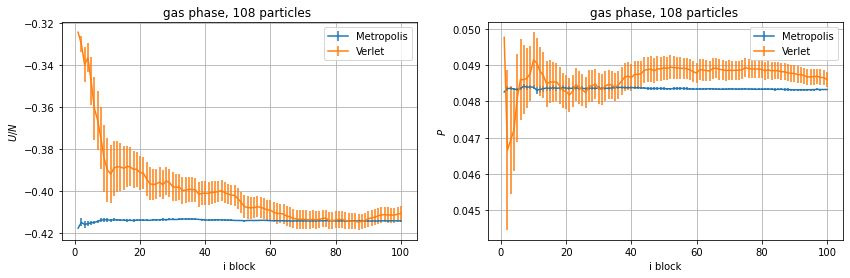

In [41]:
fig, axes = plt.subplots(1, Nobs, figsize=(14, 4))

for ax, i in zip(axes, range(Nobs)) :
    filename="output_" + phase + "_" + strings[i] + ".dat"
    Nblocks_vec[i], Y_vec[i], Y_err_vec[i] = load_Y_data(path_MC, filename)
    plot_Y_data(ax, Nblocks_vec[i], Y_vec[i], Y_err_vec[i], phase , Obs[i],  "Metropolis")
    Nblocks_vec[i], Y_vec[i], Y_err_vec[i] = load_Y_data(path_MD, filename)
    plot_Y_data(ax, Nblocks_vec[i], Y_vec[i], Y_err_vec[i], phase ,  Obs[i], "Verlet")

I tried even to check wheter the Monte Carlo predictions where compatible with the Verlet predictions. It is evident they are not compatible within two sigmas. The only phase that shows compatible results is the gas phase, which I expected to be the hardest to find correct, since how different is the evolution of the gas using the two algorithms.

Even if not compatible at least the predictions are on the same scale, which makes me think that maybe choosing more suitbale parameters for the Verlet could solve the problem. For example I don't think that in the Verlet case we reach exactly the same temperatures at which the Monte Carlo works. This just to say that there could be some problems in the set up. 

As I have already said in the lecture 4, the Verlet algorithm determines numerically the trajectory the system follows in the phase space. So we can think that the Verlet average predictions are time averages. Though, due to finite precision perturbations, the trajectory obtained numerically will diverge from the true trajectory, as the time of the simulation proceeds. If this happens then we aren't really calculating the time averages. Even if the trajectory is not the true dyanmical one, we are still sampling the costant energy hypersurface of the phase space, since the Verlet conserves Energy. So if the simulation is long enough we should be able to say that the Verlet estimates are Microcanonical ensemble averages. Instead as said before the Monte Carlo averages are Canoncal averages. So from these results we expected to find an instance of the equivalence between the Canonical and the Microcanonical ensemble.

(Note: the ensembles should be equivalent in the thermodyanmic limit, it is obvious that 108 is a samll number of particles, but the PBC should help in having a system with large N. I personally don't know if this can be another reason for the discrepancies found, but for sure it could be checked more throughly)

## Radial distribution confrontation

In [42]:
def load_gr_data(path ,Y_file) : #y is the typo of observable
    X, Y, Y_err = np.loadtxt(path + Y_file ,unpack=True)
    return X, Y, Y_err

def plot_gr_hist(ax, X, Y , phase, typeofev) :
    ax.plot(X, Y, label=f"{typeofev}") 
    ax.set_xlabel('dr bins')
    ax.set_ylabel(f"$g(r)$")
    ax.set_title(f"g(r) for {phase} phase")
    ax.legend()
    ax.grid(True)
    
def plot_gr_err(ax, X, Y , phase, typeofev) :
    ax.plot(X, Y, label=f"{typeofev}") 
    ax.set_xlabel('dr bins')
    ax.set_ylabel(f"$\sigma$")
    ax.set_title(f"errors on g(r) estimate for {phase} phase")
    ax.legend()
    ax.grid(True)

In [43]:
Nphase=len(phases)
phases=["solid", "liquid", "gas"]

X= np.empty(Nphase, dtype=object) #vector with i bloxk step index
gr = np.empty(Nphase, dtype=object) #value of the observable per block
gr_err= np.empty(Nphase, dtype=object) #err of the observable per block

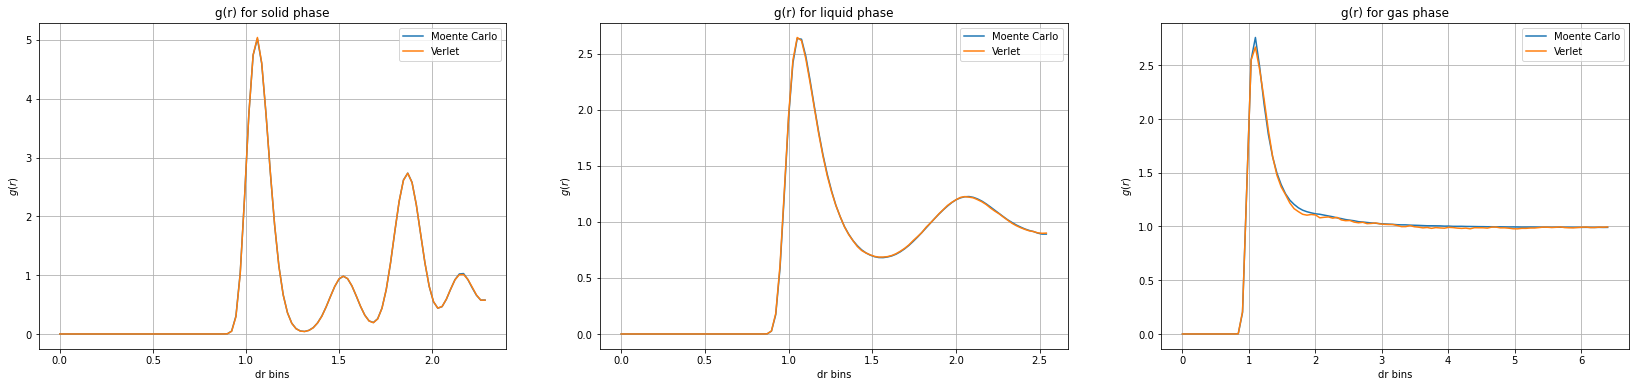

In [44]:

fig, axes = plt.subplots(1, Nphase, figsize=(28.5, 6))

for ax, j in zip(axes, range(Nphase)) :  
    filename = "gr_final_" + phases[j] + ".dat" 
    X[j], gr[j], gr_err[j] = load_gr_data(path_MC, filename ) 
    plot_gr_hist(ax, X[j], gr[j], phases[j],"Moente Carlo") 
    X[j], gr[j], gr_err[j] = load_gr_data(path_MD, filename ) 
    plot_gr_hist(ax, X[j], gr[j], phases[j], "Verlet")     


In this case instead the predictions are complitely compatible over all the domain. The Microcanonical and the Canonical ensemble gives us the same prediction for the radial distribution.

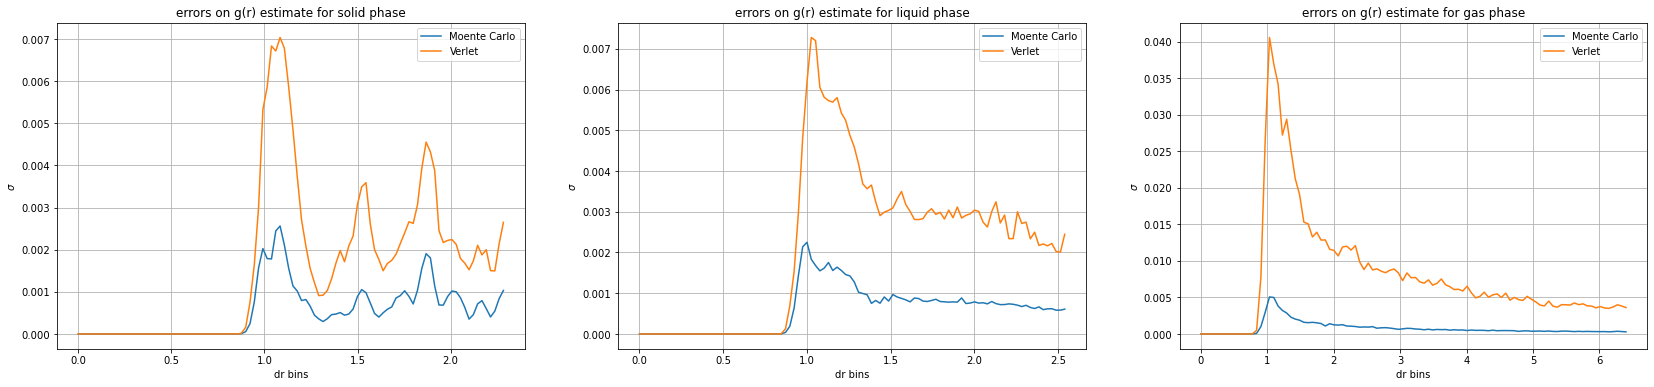

In [45]:
fig, axes = plt.subplots(1, Nphase, figsize=(28.5, 6))

for ax, j in zip(axes, range(Nphase)) :  
    filename = "gr_final_" + phases[j] + ".dat" 
    X[j], gr[j], gr_err[j] = load_gr_data(path_MC, filename ) 
    plot_gr_err(ax, X[j], gr_err[j], phases[j],"Moente Carlo") 
    X[j], gr[j], gr_err[j] = load_gr_data(path_MD, filename ) 
    plot_gr_err(ax, X[j], gr_err[j], phases[j], "Verlet")     


The radial distributions are perfectly compatible for both algorithms. And the Monte Carlo results are characterised by a lower error. 